## 🧠 DenseNet121 Transfer Learning (CheXNet-style)
This block loads DenseNet121 pretrained on ImageNet, freezes the base layers, and trains a custom head for pneumonia classification.

In [ ]:
# 🔧 Install kagglehub
!pip install kagglehub --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)

In [ ]:
# 🔐 Authenticate Kaggle API using kaggle.json
import os, shutil
shutil.move("/content/kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("✅ Kaggle API is now authenticated.")

✅ Kaggle API is now authenticated.


In [ ]:
# 📦 Import and download dataset using kagglehub
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("✅ Path to dataset files:", path)

✅ Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
# 🧹 Data Preprocessing and Augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define base_dir
base_dir = f"{path}/chest_xray" # Assuming 'path' is defined in a previous cell

train_path = f"{base_dir}/train"
val_path = f"{base_dir}/val"
test_path = f"{base_dir}/test"

# Create output directory in a writable location
output_dir = os.path.join('/tmp', 'densenet121')
os.makedirs(output_dir, exist_ok=True)

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)
val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_path, target_size=(224, 224), class_mode='binary')
val_data = val_test_gen.flow_from_directory(val_path, target_size=(224, 224), class_mode='binary')
test_data = val_test_gen.flow_from_directory(test_path, target_size=(224, 224), class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load DenseNet121 base
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

# Build top model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.8106 - loss: 0.4645

131/131 ━━━━━━━━━━━━━━━━━━━━ 160s 975ms/step - accuracy: 0.8111 - loss: 0.4632 - val_accuracy: 0.9453 - val_loss: 0.1419
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9278 - loss: 0.1857

131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 431ms/step - accuracy: 0.9278 - loss: 0.1857 - val_accuracy: 0.9616 - val_loss: 0.1169
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9301 - loss: 0.1766

131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 425ms/step - accuracy: 0.9301 - loss: 0.1766 - val_accuracy: 0.9597 - val_loss: 0.1107
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 412ms/step - accuracy: 0.9327 - loss: 0.1626 - val_accuracy: 0.9597 - val_loss: 0.1165
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9404 - loss: 0.1528

131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 438ms/step - accuracy: 0.9404 - loss: 0.1528 - val_accuracy: 0.9607 - val_loss: 0.0986
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 418ms/step - accuracy: 0.9509 - loss: 0.1311 - val_accuracy: 0.9588 - val_loss: 0.1095
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9514 - loss: 0.1335

131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 419ms/step - accuracy: 0.9514 - loss: 0.1336 - val_accuracy: 0.9655 - val_loss: 0.0953
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9437 - loss: 0.1379

131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 430ms/step - accuracy: 0.9437 - loss: 0.1379 - val_accuracy: 0.9684 - val_loss: 0.0903
Epoch 9/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 417ms/step - accuracy: 0.9420 - loss: 0.1376 - val_accuracy: 0.9578 - val_loss: 0.1045
Epoch 10/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 417ms/step - accuracy: 0.9483 - loss: 0.1223 - val_accuracy: 0.9655 - val_loss: 0.0908
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8506 - loss: 0.4265   
Test Accuracy: 84.78%


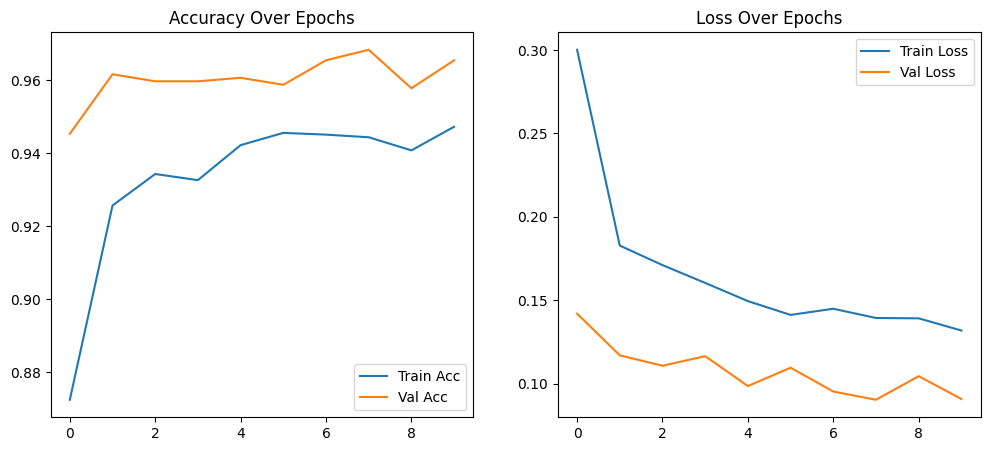

In [ ]:
# 1. Install dependencies (if needed)
# !pip install tensorflow

# 2. Import required libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# 3. Set paths
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray' # Corrected path
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# 4. Data Preparation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# 5. Load DenseNet121 with ImageNet weights
base_model = DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # freeze base

# 6. Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# 7. Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 8. Set Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_densenet121_model.h5', save_best_only=True)
]

# 9. Train the Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)

# 10. Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_data)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# 11. Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

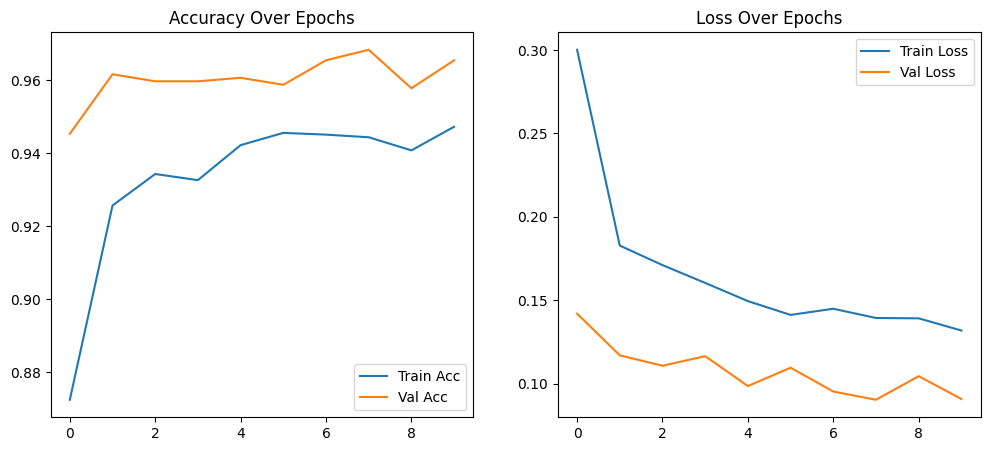

In [ ]:
import json
import os
import matplotlib.pyplot as plt

# Create the directory if it doesn't exist
output_dir = '/content/chest_xray/densenet121'
os.makedirs(output_dir, exist_ok=True)

# Save training history
with open(os.path.join(output_dir, 'logs.json'), 'w') as f:
    json.dump(history.history, f)

# Plot and save accuracy/loss graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.savefig(os.path.join(output_dir, 'accuracy_loss.png'))
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
preds = model.predict(test_data)
y_pred = (preds > 0.5).astype("int32")
y_true = test_data.classes

# Confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=test_data.class_indices.keys())

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", cr)


20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 861ms/step
Confusion Matrix:
 [[ 57 177]
 [ 86 304]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.40      0.24      0.30       234
   PNEUMONIA       0.63      0.78      0.70       390

    accuracy                           0.58       624
   macro avg       0.52      0.51      0.50       624
weighted avg       0.54      0.58      0.55       624



In [ ]:
import shutil
import os

# Define source and destination paths
src_path = "/content/chest_xray/densenet121"
dst_path = "/content/drive/MyDrive/chest_xray_backups/densenet121"

# Create destination directory if it doesn't exist
os.makedirs(dst_path, exist_ok=True)

# Copy entire directory
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print(f"✅ Model outputs successfully backed up to: {dst_path}")


✅ Model outputs successfully backed up to: /content/drive/MyDrive/chest_xray_backups/densenet121


In [ ]:
shutil.make_archive('/content/drive/MyDrive/densenet121_submission', 'zip', dst_path)


'/content/drive/MyDrive/densenet121_submission.zip'